# Problem Set 6

See [Visualization Rules](https://datascience.quantecon.org/../applications/visualization_rules.html) and [Regression](https://datascience.quantecon.org/../applications/regression.html)

In [1]:
#! pip install patsy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import sklearn
import sklearn.model_selection
import sklearn.ensemble

# Custom imports 
from sklearn.linear_model import LinearRegression, Lasso, lasso_path, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

This problem set uses data on insuree characteristics and medical costs. This is a public domain dataset downloaded from [kaggle](https://www.kaggle.com/mirichoi0218/insurance). 

The variables in the data are:
- age: age of primary beneficiary
- sex: insurance contractor gender, female, male
- bmi: Body mass index of primary beneficiary
- children: Number of children covered by health insurance / Number of dependents
- smoker: whether primary beneficiary smokes
- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- charges: medical costs billed by health insurance

You will build a  model to predict charges given the other variables in the data. 


In [2]:
insure = pd.read_csv("https://raw.githubusercontent.com/doctor-phil/ECON323_2023_Spring/main/problem_sets/insurance.csv")
insure.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Questions 1-3

These question are intentionally open-ended. For each one, carefully choose the type of visualization you’ll create. Put some effort into choosing colors, labels, and other formatting.

### Question 1

Create a visualization showing the relationship between smoking and medical costs. 

In [3]:
insure.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


In [4]:
# helper function to graph
# x1 and x2 are variables of interest
# def helper_viz(df, x1, x2):
#     fig, ax = plt.subplots()
#     x1 = df[x1]
#     x2 = df[x2]
#     ax.plot(x1, x2)
#     return 0

<BarContainer object of 1338 artists>

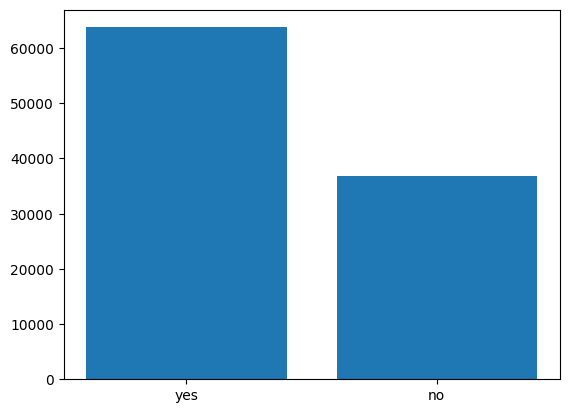

In [5]:
# your code here
# show relationship between smoking (binary) and medical costs
fig, ax = plt.subplots()
ax.bar(insure["smoker"], insure["charges"])


### Question 2

Create a visualization showing the relationship between BMI and medical costs. 

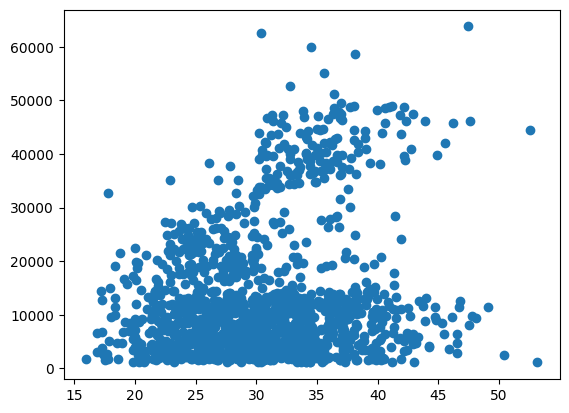

In [6]:
# your code here

# showing the relationship between BMI and medical costs.
fig, ax = plt.subplots()
ax.scatter(x = insure["bmi"], y = insure["charges"])


### Question 3

Does the relationship between medical costs and BMI vary with gender? Create a visualization to answer this question.

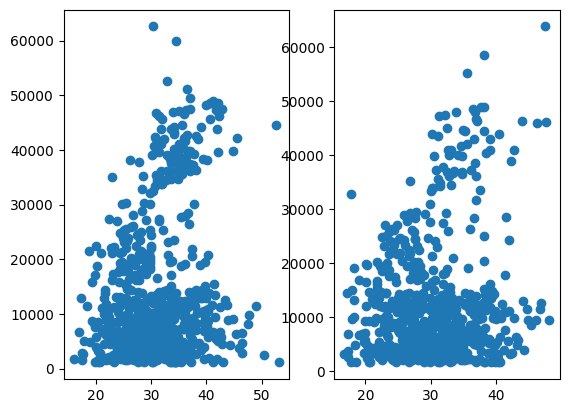

In [7]:
# your code here

# Does the relationship between medical costs and BMI vary with gender
males = insure.query("sex == 'male'")
females = insure.query("sex == 'female'")
fig, ax = plt.subplots(1,2)
ax[0].scatter(males["bmi"], males["charges"],)
ax[1].scatter(females["bmi"], females["charges"])

## Questions 4-7

In these questions you will build and evaluate a model to predict medical costs. 

First, we divide the data into training and testing sets. 

In [8]:
train = insure.sample(frac = 0.8,random_state = 42) 
test = insure.drop(train.index)

Now we create a numeric matrix of features from our dataframe. The formula interface from the patsy package is one convenient method for doing this.

In [9]:
y, X = patsy.dmatrices("charges ~ C(sex)*(age + children + C(smoker) + C(region)) + age:C(smoker)", insure, return_type='matrix')
y = y.flatten()
y_train = y[train.index]
X_train = X[train.index]
y_test = y[test.index]
X_test = X[test.index]

### Question 4

Fit a linear regression model to the training data. Print the MSE on the training and testing data.

In [10]:
# helper to get mses
def report_mses(mod, X_train, X_test, y_train, y_test, name):
    out = dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test))
    )
    print(f"""
    The train MSE of {name} is {round(out["mse_train"], 3)}
    The test MSE of {name} is {round(out["mse_test"], 3)}
    """)
    return out

In [11]:
# your code here

# construct OLS model, fit it to the train data
ols_mod = LinearRegression().fit(X_train, y_train)

# OLS train and test mses
ols_mses = report_mses(ols_mod, X_train=X_train, X_test=X_test,
                                         y_train=y_train, y_test=y_test, name="OLS")


    The train MSE of OLS is 38781234.249
    The test MSE of OLS is 45740307.025
    


### Question 5

Fit a LASSO model to the training data. Follow along with the notes on regression to visualize the lasso path. `alpha`. Print the MSE on the training and testing data.


    The train MSE of LASSO is 38781549.541
    The test MSE of LASSO is 45709751.071
    
{'mse_train': 38781549.54087569, 'mse_test': 45709751.07084894}


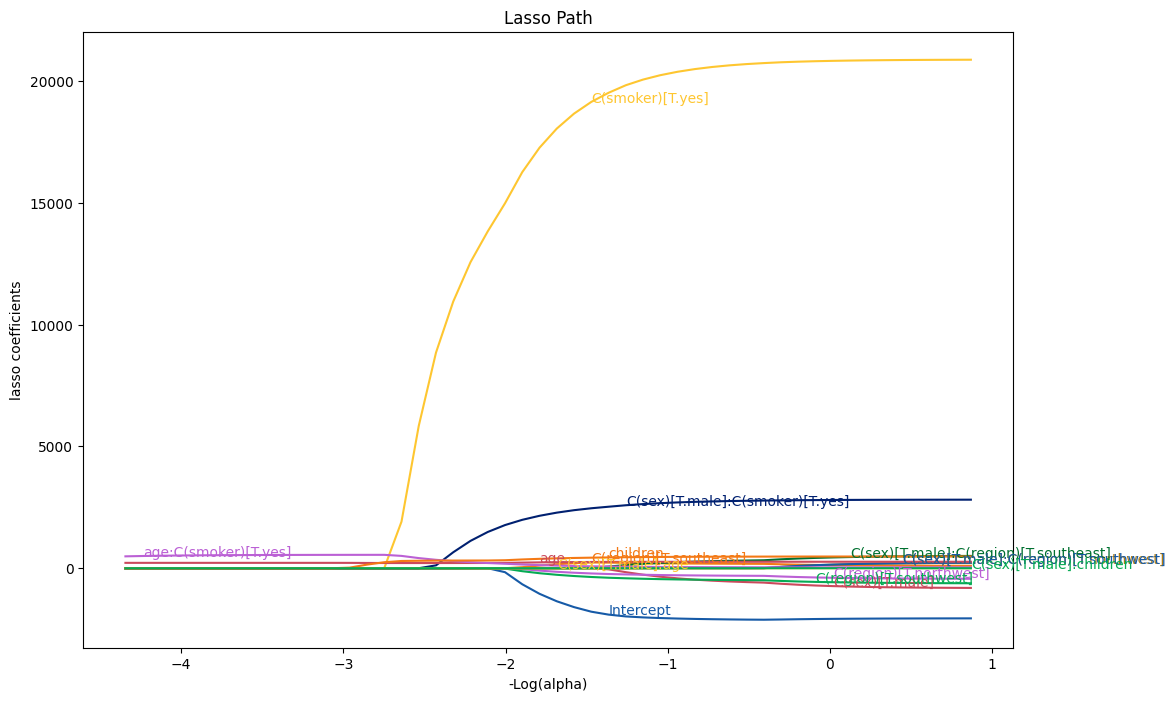

In [12]:
# your code here

# Fit LASSO model to train data, note takes default alpha=1.0
lasso_mod = Lasso().fit(X_train, y_train)

# report mses
lasso_mses = report_mses(lasso_mod, X_train=X_train, X_test=X_test,
                                         y_train=y_train, y_test=y_test, name="LASSO")
print(lasso_mses)
# Visualize the lasso path
# adoated from lecture


# plotting
def viz_lasso_alpha():
    # Compute lasso for many alphas (the lasso path)

    from itertools import cycle
    alphas = np.exp(np.linspace(10, -2, 50))
    alphas, coefs_lasso, _ = lasso_path(X, y, alphas=alphas, max_iter=10000)
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = ['#165aa7', '#cb495c', '#fec630', '#bb60d5', '#f47915', '#06ab54', '#002070', '#b27d12', '#007030']
    color_cycle = cycle(colors)
    log_alphas = -np.log10(alphas)
    for coef_l, c, name in zip(coefs_lasso, color_cycle, list(X.design_info.column_names)):
        ax.plot(log_alphas, coef_l, c=c)
        ax.set_xlabel('-Log(alpha)')
        ax.set_ylabel('lasso coefficients')
        ax.set_title('Lasso Path')
        ax.axis('tight')
        maxabs = np.max(np.abs(coef_l))
        i = [idx for idx in range(len(coef_l)) if abs(coef_l[idx]) >= (0.9*maxabs)][0]
        xnote = log_alphas[i]
        ynote = coef_l[i]
        ax.annotate(name, (xnote, ynote), color=c)
viz_lasso_alpha()



### Question 6

Estimate a regression tree using the training, data with maximum depth of 3 layers. Set the `random_state` keyword argument to `123`. Report the mean-square error on the training and testing samples as a formatted string. 

Then estimate a regression tree with a maximum depth of 10, and the same value of `random_state` and report its MSE on the test data in the same way.

Which model had a higher MSE on the testing data? Explain why you think this might be.

In [13]:
# Estimate RF with train data, max depth of 3, random state 123
def rf_model(X, y, max_depth, random_state=123):
    rf_mod = RandomForestRegressor(max_depth=max_depth, random_state=123).fit(X, y)
    return rf_mod
# report MSEs for maximum depth 3
rf_mod_max_3 = rf_model(X=X_train, y=y_train, max_depth=3)
rf_mod_max_3_mses = report_mses(mod=rf_mod_max_3, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, name="Random Forest Regressor with max depth 3")

# report MSEs for maximum depth 10
rf_mod_max_10 = rf_model(X=X_train, y=y_train, max_depth=10)
rf_mod_max_10_mses = report_mses(mod=rf_mod_max_10, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, name="Random Forest Regressor with max depth 10")


    The train MSE of Random Forest Regressor with max depth 3 is 37107566.363
    The test MSE of Random Forest Regressor with max depth 3 is 46548110.617
    

    The train MSE of Random Forest Regressor with max depth 10 is 14243762.201
    The test MSE of Random Forest Regressor with max depth 10 is 56039073.12
    


> Which model had a higher MSE on the testing data? Explain why you think this might be.

The **Random Forest Regressor with maximum depth 10** had higher test `Mean Squared Error (MSE)`, this is because it went further with chances to **overfit** to the training data, hence not able to generalize patterns, thus having higher error when predicting the test data ("unseen data").

### Question 7

Perform k-fold cross-validation on the $\alpha$ parameter in your lasso regression, with $k$ equal to `5`. What is the optimal value of $\alpha$ that it chooses? Compare that value of $\alpha$ to the visualization from question 5. How many of your variables have parameters at this level of $\alpha$?

In [14]:
# perform k fold cv on alpha, with k = 5
def k_fold_cv_viz(k):
    alphas = np.exp(np.linspace(10, -5, 100))
    mse = pd.DataFrame()
    mse["log_alpha"] = np.log10(alphas)
    mse["cv"] = [-np.mean(cross_val_score(Lasso(alpha=alpha, max_iter=50000),
                                      X_train, y_train, cv=k, scoring='neg_mean_squared_error'))
              for alpha in alphas]
    return mse

fold_cv_5 = k_fold_cv_viz(k=5)
optimal = fold_cv_5.loc[fold_cv_5.cv.argmin()]
log_alpha = optimal.log_alpha
opt_alpha = np.exp(log_alpha)
print(f"The optimal log alpha is {round(log_alpha, 3)}, equivalent to alpha = {round(opt_alpha, 3)} with cv: {round(optimal.cv, 3)}")

The optimal log alpha is 1.448, equivalent to alpha = 4.253 with cv: 39855603.454


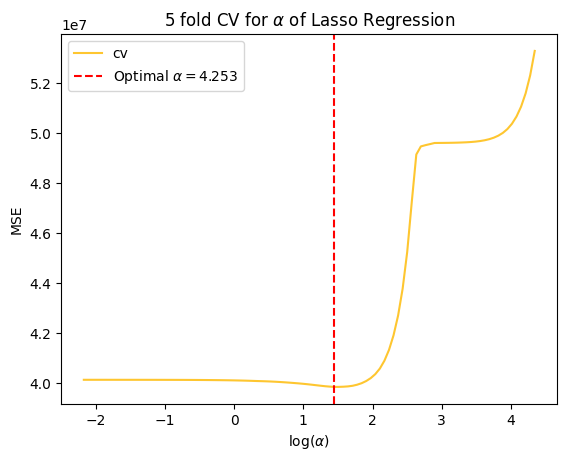

In [15]:
# create plots
fig, ax = plt.subplots()
fold_cv_5.plot(x="log_alpha", y="cv", c='#fec630', ax=ax)
ax.set_xlabel(r"$\log(\alpha)$")
ax.set_ylabel("MSE")
# add anotation to optimal , and take inverse of natural log to get back alpha
ax.axvline(x=log_alpha, color='red', label=r'Optimal $\alpha = $' + f'{round(opt_alpha, 3)}', ls='--')
ax.set_title(r'5 fold CV for $\alpha$ of Lasso Regression')
plt.legend()
plt.show()

In [16]:
# This is using function from scikit learn
lasso = LassoCV(cv=5).fit(X_train,y_train)
-np.log10(lasso.alpha_) # should roughly = minimizer on graph, not exactly equal due to random splitting

-2.2032997833678833

# This should answer in markdown:
> What is the optimal value of $\alpha$ that it chooses? Compare that value of $\alpha$ to the visualization from question 5. How many of your variables have parameters at this level of $\alpha$?